In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry
from agents import run_episode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define environment

In [31]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=0, sigma=5, quantization=4, cost=1.00, seed=None, branching=[3,1,2], **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            x = np.array([-2,-1,1,2])
            return Categorical(mu + sigma * x)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

env = make_env(ground_truth=False)

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [271]:
from exact import solve
from toolz import compose
h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

from policies import SoftmaxPolicy

Q, V, pi, info = solve(env, hash_state=hash_x12)
print(V(env.init))  # ~ 5 minutes for 312
optimal_policy =  SoftmaxPolicy(Q)

8.879117548465729


# Alternative models

## Satisficing and pruning

In [33]:
from functools import wraps

def observed(state, node):
    return not hasattr(state[node], 'sample')

@curry
def satisfruning(preference, prune=None, satisfice=None, env=env):
    @wraps(preference)
    def new_pref(state, action, prune=prune, satisfice=satisfice):
        if action == env.term_action:
            if satisfice is not None:
                satisfied = env.expected_term_reward(state) >= satisfice
                return 1e10 if satisfied else -1e10
        elif prune is not None:
            if env.node_quality(action, state).expectation() <= prune:
                return -1e20
        return preference(state, action)
    
    return new_pref

## Preferences

In [34]:
def depth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are further from the start
    return len(previous_nodes)

In [35]:
def breadth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are closer to the start
    return -len(previous_nodes)

In [36]:
def best_first(state, action):
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    q = env.node_quality(action, state)  # note backwards arguments!  plz don't ask why...
    return q.expectation()  # node_quality is a distribution, we just want the mean

In [37]:
def progressive_deepening(state, action,  last_click=None):
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    if last_click:
        # version if last_click is available
        if last_clicka in env.leaves():
            if len(previous_nodes) == 1:
                # the start of a new path = another leaf on the previous path
                return len(env.path_to(last_click)[:-1])
            return len(previous_nodes)
        if last_click == previous_nodes[-1]:
            return 1e10
        return len(previous_nodes)
    else:
        # the following only works for a 3-1-2 environment
        if action in env.leaves():
            leaf_group = None
            for subtree in env.tree:
                if (len(subtree) == 2) and (action in subtree):
                    leaf_group = subtree
            for leaf in leaf_group:
                if observed(state, leaf):
                    return 1 # set same value as the beginning of a new path
        return len(previous_nodes)

# Model human data

## Load and preprocess

In [38]:
from analysis_utils import *
VERSION = 'c1.1'
exp_data = get_data(VERSION, '../experiment/data')

pdf = exp_data['participants']
pdf = pdf.loc[pdf.completed].set_index('pid')
if 'variance' not in pdf:
    pdf['variance'] = 'constant'

print(f'{len(pdf)} participants')
complete = list(pdf.index)

def extract(q):
    return list(map(int, q['click']['state']['target']))

mdf = exp_data['mouselab-mdp'].query('pid == @complete').copy()
mdf['clicks'] = mdf.queries.apply(extract)
mdf['n_clicks'] = mdf.clicks.apply(len)
mdf['thinking'] = mdf['rt'].apply(get(0, default=0))

tdf = mdf.query('block == "test"').copy()
tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

# pdf['total_time'] = exp_data['survey'].time_elapsed / 60000

pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.mean()
pdf['thinking'] = mdf.groupby('pid').thinking.mean()

60 participants


In [39]:
import json
def excluded_pids():
    sdf = exp_data['survey-multi-choice'].query('pid == @complete').set_index('pid')
    responses = pd.DataFrame(list(sdf.responses), index=sdf.index)
    grp = responses.groupby(lambda pid: pdf.variance[pid])
    correct = grp.apply(lambda x: x.mode().iloc[0])
    errors = correct.loc[pdf.variance].set_index(pdf.index) != responses
    fail_quiz = errors.sum(1) > 1

    no_click = mdf.query('block == "train_inspector"').groupby('pid').n_clicks.sum() == 0
    return fail_quiz | no_click

exclude = excluded_pids()
tdf['exclude'] = list(exclude.loc[tdf.pid])
tdf = tdf.query('~exclude').copy().drop('exclude', axis=1)
print(f'excluding {exclude.sum()} out of {len(exclude)} partipicants')

excluding 9 out of 60 partipicants


In [40]:
def get_env(state_rewards):
    state_rewards[0] = 0
    return make_env(ground_truth=state_rewards)
tdf['env'] = tdf.state_rewards.apply(get_env)

# assert len(tdf.pid.unique()) == tdf.pid.max() + 1
def expand(df):
    for i, row in df.iterrows():
        env = row.env
        env.reset()
        for a in [*row.clicks, env.term_action]:
            yield {'pid': row.pid, 'trial_index': row.trial_index, 'trial_id': row.trial_id,
                   'state': env._state, 'action': a}
            env.step(a)

data = pd.DataFrame(expand(tdf))
print(f'{len(data)} observations)')
data.head()

7606 observations)


,action,pid,state,trial_id,trial_index
0,9,1,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",8034619116489218048,0
1,13,1,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",8034619116489218048,0
2,5,1,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",38024071126860576,1
3,9,1,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",38024071126860576,1
4,13,1,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",38024071126860576,1


## Likelihood model

In [41]:
class MouselabModel():
    """Computes likelihoods for a softmax policy on a grid of temp and p_error."""
    def __init__(self, env, preference, data):
        self.env = env
        self.policy = SoftmaxPolicy(preference)
        self.data = data
        run_episode(self.policy, self.env)
        self.prefs = np.stack(self.data.state.apply(self.policy.preferences))
        self.prefs -= self.prefs.max(1).reshape(-1, 1)  # prevent float overflow 

        idx = np.arange(len(data))
        self.chosen = (idx, data.action.as_matrix())

    def likelihood(self, temp=1e-9, p_error=None):
        """Returns likelihood for all combinations of temp and p_error given.
        
        Return value has shape (len(self.data), len(temp), len(p_error)).
        """
        temp = np.atleast_1d(temp)
        ep = np.exp(np.einsum('ij,k -> ijk', self.prefs, 1/temp))
        probs = ep[self.chosen] / ep.sum(1)  # shape: (state, temp)
        if p_error is not None:
            p_error = np.atleast_1d(p_error)
            probs = (probs[..., np.newaxis] * (1-p_error) + 
                     self.random_likelihood[..., np.newaxis] * p_error)
        return probs

    @property
    @memoize
    def random_likelihood(self):
        return MouselabModel(self.env, lambda *_: 0, self.data).likelihood()

## Parameters to search over

In [232]:
path_values = range(-30, 31, 5)
defaults = {
    'p_error': np.linspace(0.01,1, 100),
    'satisfice': [v for v in path_values if v > 0],
    'prune': [v for v in path_values if v < 0],
    'temp': np.logspace(-5,1, 50),
}
models = {
    'depth_first': {
        **defaults,
        'pref': depth_first,  
        'temp': [1e-10]
    },
    'breadth_first': {
        **defaults,
        'pref': breadth_first,
        'temp': [1e-10]
    },
    'progressive_deepening': {
        **defaults,
        'pref': progressive_deepening,
        'temp': [1e-10]
    },
    'best_first': {
        **defaults,
        'pref': best_first,
    },
    'optimal': {
        **defaults,
        'pref': Q,
        'satisfice': [None],
        'prune': [None],
    },
    'random': {
        **defaults,
        'pref': lambda s, a: 0,
        'prune': [None],
        'satisfice': [None],
        'p_error': [1],
        'temp': [1e-10]
    },
#     'satisfruning_optimal': {
#         **defaults,
#         'pref': Q,
#     },
#     'satisfruning_random': {
#         **defaults,
#         'pref': lambda s, a: 0,
#         'temp': [1e-10]
#     },
}

# Find MLE

In [233]:
def best_logp(df, n=1, group=None):
    if group:
        return df.groupby(group).apply(lambda d: d.nlargest(n, 'logp')).reset_index(drop=True)
    else: 
        return df.nlargest(n, 'logp')

def maximum_likelihood(data, pref, temp, p_error, satisfice, prune, 
                       n_keep_temp_error=1, n_keep_sat_prn=1):
    choices = []
    for sat in satisfice:
        for prn in prune:
            new_pref = satisfruning(pref, prune=prn, satisfice=sat)
            model = MouselabModel(env, new_pref, data)
            logp = np.log(model.likelihood(temp=temp, p_error=p_error))
            total_logp = logp.sum(0)  # sum logp for each state/action
            
            idx = pd.MultiIndex.from_product([temp, p_error], names=['temp', 'p_error'])
            grid = pd.Series(total_logp.flat, index=idx, name='logp').reset_index()
            grid['satisfice'] = sat
            grid['prune'] = prn
            choices.append(best_logp(grid, n_keep_temp_error))
            
    df = best_logp(pd.concat(choices), n_keep_sat_prn)
    return df

## MLE for full dataset

In [230]:
def fit_models():
    for name, params in models.items():
        print(name)
        mle = maximum_likelihood(data, **params)
        mle['model'] = name
        yield mle

agg_results = pd.concat(fit_models())

depth_first


/usr/local/lib/miniconda3/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:274: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


breadth_first
progressive_deepening
best_first
optimal
random


## MLE parameters for each model and each participant

In [236]:
from tqdm import tqdm
def fit_participants(data):
    def pid_mle():
        for pid, pid_data in tqdm(data.groupby('pid')):
            for name, params in models.items():
                mle = maximum_likelihood(pid_data, **params)
                mle['pid'] = pid
                mle['model'] = name
                yield mle
    return pd.concat(pid_mle()).reset_index(drop=True)

ind_results = fit_participants(data).set_index('pid')


  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/miniconda3/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:274: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/local/lib/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 51/51 [12:14<00:00, 14.40s/it]


# Analyze results

In [247]:
consider = [
    'best_first',
    'optimal',
    'depth_first',
    'progressive_deepening',
    'breadth_first',
    'random'
]
def num_params(params):
    return sum(len(choices) > 1 if hasattr(choices, '__len__') else 0 
               for choices in params.values())
k = pd.Series({model: num_params(params) for model, params in models.items()})

In [248]:
dc = pd.DataFrame(list(np.load('dc_mles2.npy')))
dc = dc.rename(columns={'participant': 'pid'}).set_index('pid')
dc['model'] = 'dc'
ind_results = ind_results.query('model != "dc"').append(dc)
k['dc'] = 2

In [249]:
N = len(ind_results.index.unique())
comp = pd.DataFrame({
    'k': k * N,
    'logp': ind_results.groupby('model').logp.sum()
})

In [250]:
# Fit Individually

ind_results['k'] = list(k.loc[ind_results.model])
ind_results['N'] = data.pid.value_counts()
ind_results['bic'] = np.log(ind_results.N) * ind_results.k - 2 * ind_results.logp
ind_results['aic'] = 2 * ind_results.k - 2 * ind_results.logp

# How many best fit?
comp['n_best_fit'] = (ind_results
 .groupby(level='pid')
 .apply(lambda df: df.nsmallest(1, 'bic').iloc[0])
 .model.value_counts()
).fillna(0).astype(int)

In [251]:
comp['bic'] = np.log(len(data)) * comp.k - 2 * comp.logp
comp['aic'] = 2 * comp.k - 2 * comp.logp
comp.sort_values('bic')

,k,logp,n_best_fit,bic,aic
best_first,204,-12444.118437,16.0,26711.322183,25296.236875
depth_first,153,-13721.885871,11.0,28811.085723,27749.771742
progressive_deepening,153,-13811.348562,NaN,28990.011105,27928.697124
breadth_first,153,-13837.460232,9.0,29042.234445,27980.920464
optimal,102,-14244.828190,7.0,29401.199034,28693.656380
random,0,-17289.756439,7.0,34579.512879,34579.512879
dc,102,-16847.182382,1.0,34605.907417,33898.364763


## Aggregrate

In [591]:
agg_results

,temp,p_error,logp,satisfice,prune,model,pp
63,1.000000e-10,0.64,-15417.880218,15,-5,depth_first,0.131721
62,1.000000e-10,0.63,-15210.313987,10,-10,breadth_first,0.135365
63,1.000000e-10,0.64,-15432.469229,15,-5,progressive_deepening,0.131469
4654,4.291934e+00,0.55,-14823.900340,15,-10,best_first,0.142420
3442,1.456348e-01,0.43,-15113.715903,None,None,optimal,0.137095
0,1.000000e-10,1.00,-17289.756439,None,None,random,0.102985


In [592]:
comp = pd.DataFrame({
    'k': k,
    'logp': agg_results.set_index('model').logp
})
comp['bic'] = np.log(len(data)) * comp.k - 2 * comp.logp
comp['aic'] = 2 * comp.k - 2 * comp.logp

In [596]:
agg_results

,temp,p_error,logp,satisfice,prune,model,pp
63,1.000000e-10,0.64,-15417.880218,15,-5,depth_first,0.131721
62,1.000000e-10,0.63,-15210.313987,10,-10,breadth_first,0.135365
63,1.000000e-10,0.64,-15432.469229,15,-5,progressive_deepening,0.131469
4654,4.291934e+00,0.55,-14823.900340,15,-10,best_first,0.142420
3442,1.456348e-01,0.43,-15113.715903,None,None,optimal,0.137095
0,1.000000e-10,1.00,-17289.756439,None,None,random,0.102985


In [595]:
comp.sort_values('bic')

,k,logp,bic,aic
best_first,4,-14823.900340,29683.547451,29655.800680
optimal,2,-15113.715903,30245.305192,30231.431806
breadth_first,3,-15210.313987,30447.438053,30426.627975
depth_first,3,-15417.880218,30862.570514,30841.760436
progressive_deepening,3,-15432.469229,30891.748536,30870.938458
random,0,-17289.756439,34579.512879,34579.512879
dc,2,NaN,NaN,NaN


In [124]:
(comp[['bic', 'aic', 'logp', 'n_best_fit']]
 .sort_values('bic')
 .fillna(0).astype(int)
 .rename(columns={'bic': 'BIC', 
                  'logp': 'LL', 'n_best_fit': 'N_P',
                  })
#  .to_latex('../../paper/tables/exp1_indiv_comp.tex')
)

,BIC,aic,LL,N_P
model,,,,
optimal,30625,30611,-15303,9
best_first,31744,31716,-15854,16
breadth_first,34078,34058,-17026,7
random,34579,34579,-17289,15
progressive_deepening,34725,34704,-17349,0
depth_first,34732,34711,-17352,4


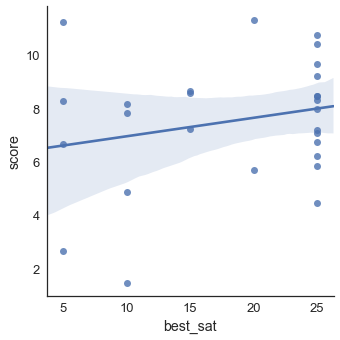

In [99]:
best_sat = ind_results.groupby('pid').apply(lambda x: x.nsmallest(1, 'bic').iloc[0]).satisfice
pdf['best_sat'] = best_sat
sns.lmplot('best_sat', 'score', data=pdf)

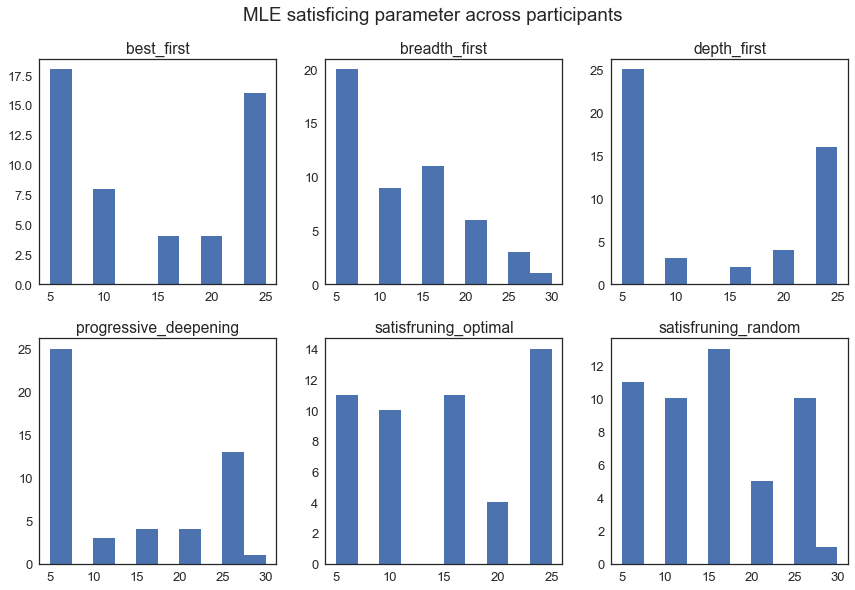

In [264]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = iter(axes.flat)
for p, dd in results.dropna().groupby('model'):
    ax = next(axes)
    dd.satisfice.plot.hist(ax=ax)
    ax.set_ylabel('')
    ax.set_title(p)
    
plt.tight_layout()
plt.suptitle('MLE satisficing parameter across participants', y=1.03)

In [391]:
mledf = best_logp(results, group='pid').set_index('pid')
mledf['high_score'] = (pdf.score > pdf.score.median())
os.makedirs(f'results/{VERSION}/', exist_ok=True)
mledf.to_csv(f'results/{VERSION}/mle.csv')

# Qualitative

## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [284]:
from agents import run_episode
def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = pd.Series([make_env() for _ in range(100)])
df_optimal = pd.DataFrame(simulate(optimal_policy, envs))
from policies import SoftmaxPolicy
best_first_policy = SoftmaxPolicy(satisfruning(best_first, satisfice=15, prune=-10))
df_best_first = DataFrame(simulate(best_first_policy, envs))

## Compare Best-First and Optimal

In [337]:
from toolz.curried import get

def mle(model, pid=slice(None), data=data):
    m = dict(models[model])
    temp = m.pop('temp')
    p_error = m.pop('p_error')
    _pref = m.pop('pref')
    def loop():
        for sf_prm in dict_product(m):
            if sf_prm.get('prune') or sf_prm.get('satisfice'):
                pref = satisfruning(_pref, **sf_prm)
            else:
                pref = _pref
            dd = data.loc[pid]
            likemod = MouselabModel(env, pref, dd)
            logp = np.log(likemod.likelihood(temp=temp, p_error=p_error))
            total_logp = logp.sum(0)  # sum logp for each state/action
            best = total_logp.argmax()
            i, j = np.unravel_index(best, total_logp.shape)
            yield {'temp': temp[i], 'p_error': p_error[j], 'N': len(dd),'likemod': likemod,
                    'logp': total_logp.flat[best], 'model': model, 'pid': pid, **sf_prm}
#     return list(loop())
    return max(loop(), key=get('logp))

def fit_models():
    for model in ['best_first', 'optimal']:
        x = mle(model)
        x['model'] = model
        yield x

comp_results = pd.DataFrame(fit_models())

In [331]:
data = data.reset_index().set_index(['pid', 'trial_index'])

,action,state,trial_id,unobserved,etr,term,observed,q,v,loss,action_type
trial_index,,,,,,,,,,,
0,9,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",8737010464064417792,12,0.0,False,0,8.879118,8.879118,0.000000,click
0,1,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",8737010464064417792,11,0.0,False,1,7.029572,7.029572,0.000000,click
0,5,"(0, 5, ((-10, 0.25), (-5, 0.25), (5, 0.25), (1...",8737010464064417792,10,5.0,False,2,9.615130,9.641675,-0.026545,click
0,13,"(0, 5, ((-10, 0.25), (-5, 0.25), (5, 0.25), (1...",8737010464064417792,9,10.0,True,3,10.000000,14.364723,-4.364723,term
1,9,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",6612009546738605056,12,0.0,False,0,8.879118,8.879118,0.000000,click
1,1,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",6612009546738605056,11,0.0,False,1,7.029572,7.029572,0.000000,click
1,5,"(0, -10, ((-10, 0.25), (-5, 0.25), (5, 0.25), ...",6612009546738605056,10,0.0,False,2,3.935963,3.964745,-0.028782,click
1,13,"(0, -10, ((-10, 0.25), (-5, 0.25), (5, 0.25), ...",6612009546738605056,9,5.0,True,3,5.000000,8.138557,-3.138557,term
2,9,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",-690593884411208960,12,0.0,False,0,8.879118,8.879118,0.000000,click


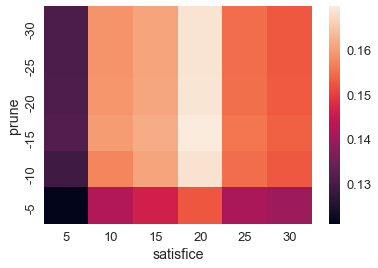

In [335]:
res = pd.DataFrame(mle('best_first', data=df_optimal))
res['pp'] = np.exp(res.logp / res.N)
sns.heatmap(res.pivot('prune', 'satisfice', 'pp'))

In [495]:
opt_models_bf = mle('optimal', data=df_best_first)
# res['pp'] = np.exp(res.logp / res.N)
# sns.heatmap(res.pivot('prune', 'satisfice', 'pp'))

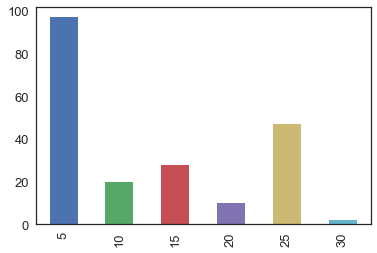

In [522]:
best_first_fits = ind_results
# sns.heatmap(best_first_fits.groupby(['prune', 'satisfice']).apply(len).unstack())
best_first_fits.satisfice.value_counts().sort_index().plot.bar()

In [501]:
df_best_first.groupby('action_type').loss.sum()

action_type
click    -71.237423
term    -165.302704
Name: loss, dtype: float64

In [311]:
ind_results['pp'] = np.exp(ind_results.logp / ind_results.N)
(ind_results
 .reset_index()
 .groupby('model')
 .apply(lambda df: df.nlargest(1, 'pp').iloc[0]))


,pid,N,aic,bic,k,logp,model,p_error,prune,satisfice,temp,pp
model,,,,,,,,,,,,
best_first,27,224,481.291386,494.937970,4,-236.645693,best_first,0.150000,-15.0,25.0,1.842070e+00,0.347687
breadth_first,30,95,181.061737,188.723368,3,-87.530869,breadth_first,0.090000,-5.0,10.0,1.000000e-10,0.397970
dc,33,186,532.752280,539.203774,2,-264.376140,dc,0.155025,NaN,NaN,3.144919e-01,0.241381
depth_first,19,97,213.306801,221.030934,3,-103.653401,depth_first,0.130000,-5.0,5.0,1.000000e-10,0.343492
optimal,27,224,590.974069,597.797361,2,-293.487034,optimal,0.090000,NaN,NaN,1.098541e-01,0.269763
progressive_deepening,19,97,215.445986,223.170119,3,-104.722993,progressive_deepening,0.130000,-5.0,5.0,1.000000e-10,0.339725
random,17,271,1106.961006,1106.961006,0,-553.480503,random,1.000000,NaN,NaN,1.000000e-10,0.129722


## Term probability

In [113]:
def plot_term(df, name, **kws):
    df['unobserved'] = df.state.apply(lambda state: sum(hasattr(x, 'sample') for x in state))
    df['etr'] = df.state.apply(env.expected_term_reward)
    df['term'] = df.action == 13
    df['observed'] = 12 - df['unobserved']
    x = df.groupby(['etr', 'observed']).term.mean().reset_index()
    X = x.pivot('etr', 'observed', 'term').astype(float)
    sns.heatmap(X, cmap='viridis', linewidths=1, **kws).invert_yaxis()
    plt.ylabel('')
    plt.xlabel('Number of Clicks Made')
    plt.title(name)

In [121]:
def best_best_first(row):
    pref = satisfruning(best_first, prune=row.prune, satisfice=row.satisfice)
    return SoftmaxPolicy(pref, temp=row.temp)
    
pid_bf_pols = ind_results.query('model == "best_first"').apply()

,temp,p_error,logp,satisfice,prune,model,k,N,bic,aic
pid,,,,,,,,,,
1,0.000010,0.25,-134.755975,5,-5,best_first,4,86,287.329339,277.511950
2,5.689866,0.15,-241.147806,25,-10,best_first,4,212,503.721956,490.295611
3,3.237458,0.24,-269.466787,25,-15,best_first,4,193,559.984335,546.933574
4,10.000000,0.25,-456.044214,20,-15,best_first,4,230,933.840746,920.088429
6,7.543120,0.11,-294.301327,25,-30,best_first,4,255,610.767707,596.602653
7,0.000010,0.25,-113.759389,5,-5,best_first,4,37,241.962451,235.518779
8,3.237458,0.25,-380.291110,10,-5,best_first,4,136,780.232840,768.582221
10,0.000010,0.25,-117.378093,5,-30,best_first,4,43,249.800986,242.756185
11,0.000010,0.25,-419.389270,5,-30,best_first,4,141,858.573579,846.778540


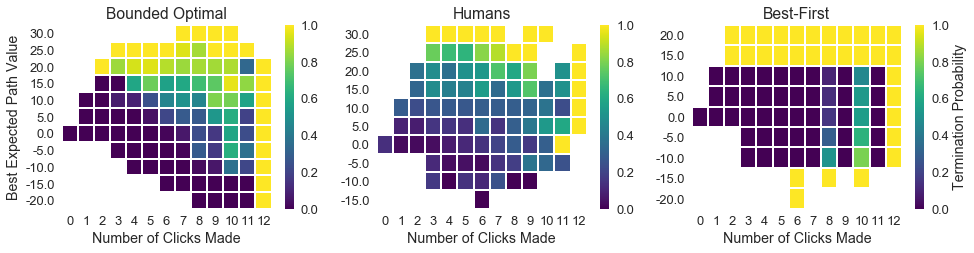

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3.5))
plt.sca(axes[0])
plot_term(df_optimal, 'Bounded Optimal')
plt.ylabel('Best Expected Path Value')

plt.sca(axes[1])
plot_term(data, 'Humans')

plt.sca(axes[2])
plot_term(df_best, 'Best-First', cbar_kws=dict(label='Termination Probability'))


plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('../../paper/figures/termination.pdf')

In [200]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

In [284]:
# select = list(pdf.query('best_model == "optimal" ').index)
rdf = data[['pid', 'term', 'etr', 'observed']]

In [285]:
%%R -i rdf
require(lme4)
m = glmer('term ~ etr * observed + (1|pid)', family='binomial', data=rdf)
print(m)
Anova(m)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: term ~ etr * observed + (1 | pid)
   Data: rdf
      AIC       BIC    logLik  deviance  df.resid 
 4851.911  4886.595 -2420.956  4841.911      7601 
Random effects:
 Groups Name        Std.Dev.
 pid    (Intercept) 2.68    
Number of obs: 7606, groups:  pid, 51
Fixed Effects:
 (Intercept)           etr      observed  etr:observed  
    -4.07858       0.25757       0.59177      -0.01601  
convergence code 0; 1 optimizer warnings; 0 lme4 warnings 
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: term
               Chisq Df Pr(>Chisq)    
etr          879.371  1  < 2.2e-16 ***
observed     581.857  1  < 2.2e-16 ***
etr:observed  43.319  1  4.651e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Action types

In [272]:
data['q'] = data.apply(lambda row: Q(row.state, row.action), 1)
data['v'] = data.state.apply(V)

df_best_first['q'] = df_best_first.apply(lambda row: Q(row.state, row.action), 1)
df_best_first['v'] = df_best_first.state.apply(V)

In [473]:
data.groupby('action_type').loss.sum()

action_type
click    -905.349476
term    -3908.228669
Name: loss, dtype: float64

In [481]:
print('Loss by action type')
print(l.groupby(level=0).agg([np.mean, np.std]))

Loss by action type
                  mean        std
action_type                      
click       -18.106990  14.839946
term        -72.837103  78.968698


In [548]:
g = data.groupby('action_type').loss
g.

In [560]:
l = (data.reset_index().set_index('pid').loc[pdf.n_clicks > 0]
     .groupby(['action_type', 'pid']).loss.sum().dropna())

In [562]:
l.click.index

Int64Index([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
            22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 42,
            45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61],
           dtype='int64', name='pid')

In [571]:
best_sat = ind_results.query('model == "best_first"').loc[l.click.index].satisfice

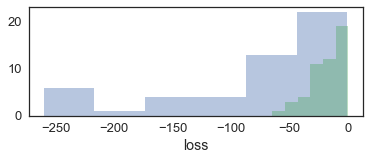

In [589]:
# for at, dd in l.groupby(level='action_type'):
fig = plt.figure(figsize=(6,2))
sns.distplot(l.term, label=at, kde=0)
sns.distplot(l.click, label=at, kde=0)
ax = plt.gca()

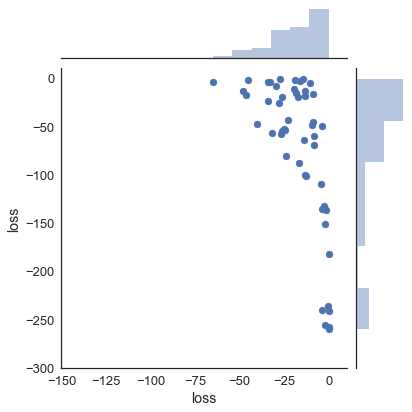

In [576]:
jp = sns.jointplot(l.click, l.term, stat_func=None,
                   xlim=(-150, 10), ylim=(-300, 10),
                   kind='scatter',
#                    joint_kws
#                    kind='kde', joint_kws=dict(shade=False)
                  )



# plt.plot(l.click, l.term, 'o')
# plt.xlabel('Click Loss')
# plt.ylabel('Term Loss')
# jp.ax_joint.set_xlim(-50, 0)
# jp.ax_joint.set_aspect('equal')

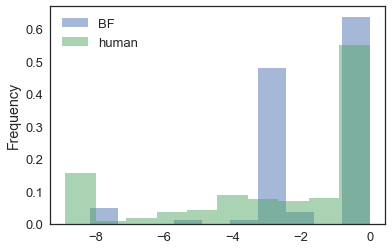

In [373]:
def action_type(action):
    if action == env.term_action:
        return 'term'
    else:
        return 'click'
        return len(env.path_to(action))

df_best_first.query('action_type == "term"').loss.plot.hist(
    alpha=0.5, normed=1, label='BF')
data.query('action_type == "term"').loss.plot.hist(
    alpha=0.5, ax=plt.gca(), normed=1, label='human')
plt.legend()
# for at, dd in data.groupby('action_type').loss:
#     ax = next(axes)
#     sns.distplot(dd, label=at, kde=0, ax=ax)

In [ ]:
data.groupby('action_type').loss.plot.hist

## View rollouts

In [ ]:
np.random.seed(1)

import json
def demo(env):
    trace = run_episode(optimal_policy, env)
    
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),
        'demo': 
    }

nr_environments = 100  # 1000 -> 100
branch = [3,1,2]
env_type = ''.join(map(str, branch))
envs = [make_env(mu=0, sigma=6, quantization=4, branching=branch)
        for _ in range(nr_environments)]

fn = 'data/experiment_trials/'+env_type+'.json'
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(env_data, envs)), f)

In [ ]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)